# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 1. Data Cleaning

In [2]:
# df = pd.read_csv('student_data.csv')
df = pd.read_csv('clean_with_new_columns.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df['default payment next month'].value_counts()

0.0    18678
1.0     5307
Name: default payment next month, dtype: int64

In [53]:
df.tail()

,Unnamed: 0,Unnamed: 0.1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_PAY,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay
23980,23980.0,23994.0,50000.0,2.0,1.0,2.0,24.0,0.0,0.0,0.0,-2.0,-2.0,-2.0,12806.0,13490.0,0.0,0.0,0.0,0.0,7522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5968.0,-6.0
23981,23981.0,23995.0,250000.0,1.0,3.0,1.0,44.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6826.0,3900.0,4482.0,43546.0,38051.0,576.0,3924.0,4482.0,43676.0,38166.0,576.0,2389.0,1.0,0.0,-115.0,-130.0,0.0,-24.0,-6.0
23982,23982.0,23996.0,50000.0,1.0,3.0,2.0,26.0,2.0,0.0,0.0,2.0,2.0,2.0,41827.0,42650.0,45930.0,44891.0,47654.0,48721.0,1800.0,4000.0,0.0,3500.0,2000.0,0.0,1.0,46721.0,44154.0,44891.0,41930.0,40850.0,8.0
23983,23983.0,23997.0,110000.0,2.0,2.0,1.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,195437.0,176420.0,63142.0,39854.0,9293.0,-1288.0,5000.0,10000.0,5048.0,2000.0,39958.0,52000.0,1.0,-41246.0,7293.0,34806.0,53142.0,171420.0,0.0
23984,23984.0,23998.0,150000.0,1.0,1.0,2.0,34.0,2.0,3.0,2.0,0.0,0.0,0.0,32355.0,31549.0,30759.0,32764.0,36229.0,79827.0,0.0,0.0,2535.0,5000.0,5000.0,3000.0,1.0,74827.0,31229.0,30229.0,30759.0,31549.0,7.0


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'LIMIT_BAL', 'SEX', 'EDUCATION',
       'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month', 'amount_owed6',
       'amount_owed5', 'amount_owed4', 'amount_owed3', 'amount_owed2',
       'late_pay'],
      dtype='object')

In [7]:
# pay_amt 5 = bill_amt6
df.shape

(23985, 32)

In [8]:
df['amount_owed6'] = df['BILL_AMT6']- df['PAY_AMT5']
df['amount_owed5'] = df['BILL_AMT5']- df['PAY_AMT4']
df['amount_owed4'] = df['BILL_AMT4']- df['PAY_AMT3']
df['amount_owed3'] = df['BILL_AMT3']- df['PAY_AMT2']
df['amount_owed2'] = df['BILL_AMT2']- df['PAY_AMT1']

In [9]:
df['late_pay'] = df["PAY_0"] + df["PAY_2"]+ df["PAY_3"]+ df["PAY_4"]+ df["PAY_5"]+ df["PAY_6"]

In [10]:
df.groupby(df['PAY_2']).mean()

,Unnamed: 0,Unnamed: 0.1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay
PAY_2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-2.0,11483.079534,11490.080532,235061.564060,1.675541,1.672879,1.508486,36.763727,-1.022629,-1.891847,-1.758735,-1.685524,-1.654576,6004.708486,4967.402995,6246.718802,6756.034942,7249.362729,7104.496173,3495.437937,5745.562396,4680.826955,4862.694176,4458.731448,4795.793677,0.178037,2645.764725,2386.668552,2075.207987,501.156406,1471.965058,-10.013311
-1.0,11236.002270,11242.809946,209467.602146,1.630830,1.684688,1.518985,36.331820,-0.678910,-0.776517,-0.787041,-0.809327,-0.826042,8173.172513,9075.561494,11299.763104,12634.866694,11720.509080,10783.939331,9179.228229,8340.237722,7375.166323,5715.130004,5314.461205,6377.085844,0.162815,5469.478126,6005.379076,5259.700371,2959.525382,-103.666735,-4.877837
0.0,11266.104006,11272.947878,152839.641412,1.589528,1.918366,1.586672,34.968743,0.070448,0.050932,0.030464,-0.016660,-0.036097,78855.899246,75121.902578,70095.346926,63379.690440,58347.401190,56103.507418,5804.282110,5594.750179,5126.106942,4886.822134,5128.743356,5367.257438,0.160413,50974.764062,53460.579056,58253.583499,64500.596747,69317.620468,0.099088
1.0,10044.473684,10050.473684,197368.421053,1.473684,1.789474,1.315789,33.789474,1.000000,-0.631579,-0.263158,-0.315789,-0.263158,54088.842105,24260.736842,49194.473684,44833.421053,45764.000000,43309.947368,5001.210526,25983.105263,4699.947368,8042.789474,3383.052632,10752.421053,0.052632,39926.894737,37721.210526,40133.473684,23211.368421,19259.526316,0.526316
2.0,16015.701373,16025.728521,107753.433408,1.564356,1.940913,1.537528,35.333440,1.343021,1.222293,0.899393,0.764293,0.689556,51291.796231,50137.271479,49304.323539,46898.006707,44747.461833,43548.145960,1817.399553,3014.813159,2791.443309,2756.575535,2760.175663,3255.859150,0.552859,40787.970297,41990.886298,44106.563398,46289.510380,48319.871926,6.918556
3.0,17071.937984,17082.709302,88023.255814,1.527132,2.065891,1.573643,34.875969,1.732558,2.155039,1.310078,1.120155,0.895349,51912.298450,51249.813953,49477.348837,47816.341085,46047.147287,43660.267442,953.368217,1203.627907,2391.096899,2310.744186,3665.562016,3726.837209,0.616279,39994.705426,43736.403101,45425.244186,48273.720930,50296.445736,10.213178
4.0,15498.142857,15507.727273,63896.103896,1.363636,2.142857,1.558442,36.558442,2.896104,3.181818,2.311688,1.506494,1.246753,58333.714286,57277.000000,54497.285714,49601.376623,46790.532468,46170.103896,683.000000,554.246753,692.402597,2561.961039,3514.077922,7531.012987,0.545455,42656.025974,44228.571429,48908.974026,53943.038961,56594.000000,15.142857
5.0,16532.944444,16543.166667,65555.555556,1.388889,2.222222,1.555556,35.722222,2.666667,4.000000,3.444444,2.444444,1.277778,71552.000000,69106.055556,67153.000000,65042.944444,61705.611111,60781.166667,194.666667,727.444444,555.555556,788.888889,9446.833333,1391.055556,0.611111,51334.333333,60916.722222,64487.388889,66425.555556,68911.388889,18.833333
6.0,16458.333333,16468.555556,127777.777778,1.444444,2.111111,1.333333,37.555556,6.111111,5.000000,4.000000,3.111111,2.111111,131339.333333,124264.555556,121285.222222,118731.777778,116763.333333,108108.222222,928.333333,215.555556,169.777778,11.777778,1009.000000,6205.333333,0.666667,107099.222222,116751.555556,118562.000000,121069.666667,123336.222222,26.333333


In [11]:
df.loc[(df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6), 'EDUCATION'] = 4

In [12]:
df['EDUCATION'].value_counts()

2.0    11183
1.0     8436
3.0     3991
4.0      375
Name: EDUCATION, dtype: int64

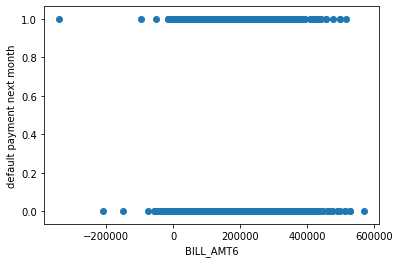

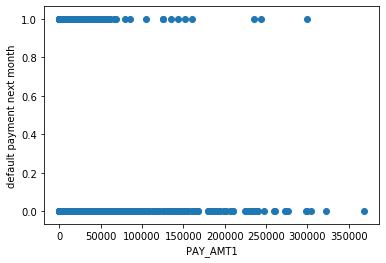

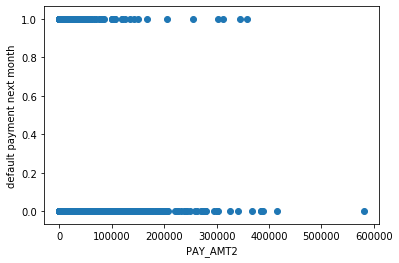

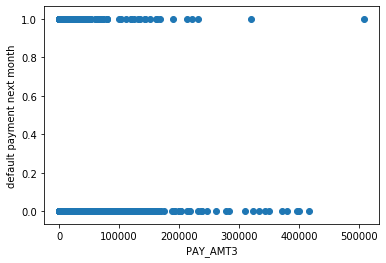

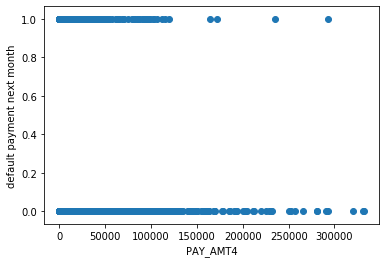

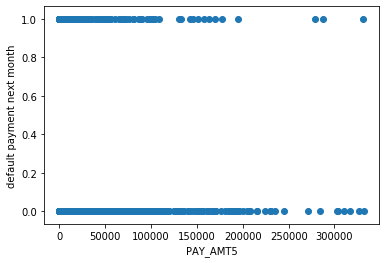

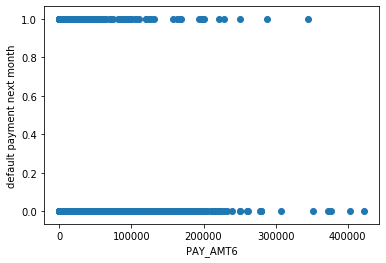

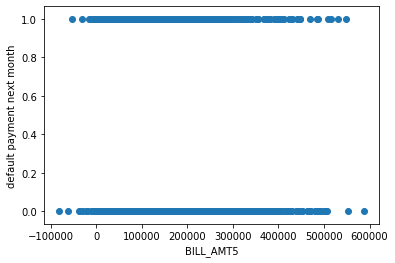

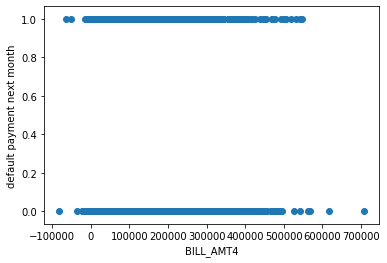

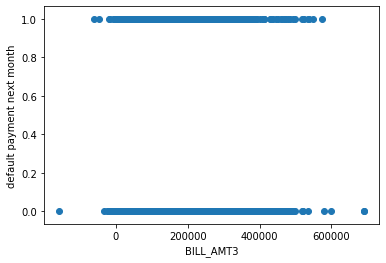

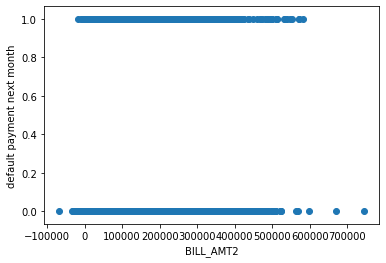

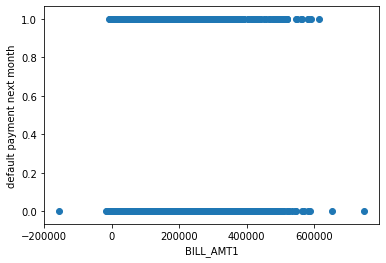

In [13]:
variable = ['BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1'] 

def bill_pay_amt(df, var):
    df = df.copy()
    
    plt.scatter(df[var], df['default payment next month'])
    plt.ylabel('default payment next month')
    plt.xlabel(var)
    plt.show()
    
for var in variable:
    bill_pay_amt(df, var)

In [14]:
df.loc[df['BILL_AMT1'] > 800000] = np.nan
df.loc[df['BILL_AMT2'] > 800000] = np.nan
df.loc[df['BILL_AMT3'] > 1000000] = np.nan
df.loc[df['BILL_AMT4'] > 800000] = np.nan
df.loc[df['BILL_AMT5'] > 800000] = np.nan
df.loc[df['PAY_AMT6'] > 500000] = np.nan
df.loc[df['PAY_AMT5'] > 350000] = np.nan
df.loc[df['PAY_AMT4'] > 400000] = np.nan
df.loc[df['PAY_AMT3'] > 600000] = np.nan
df.loc[df['PAY_AMT2'] > 750000] = np.nan
df.loc[df['PAY_AMT1'] > 400000] = np.nan
df.loc[df['BILL_AMT6'] > 600000] = np.nan

df.dropna(inplace = True)

In [15]:
df['PAY_6'].value_counts()

 0.0    13087
-1.0     4555
-2.0     3878
 2.0     2211
 3.0      146
 4.0       42
 7.0       39
 6.0       14
 5.0       11
 8.0        2
Name: PAY_6, dtype: int64

In [16]:
df.shape

(23985, 32)

In [17]:
# df.to_csv('clean_with_new_columns.csv')

In [18]:
df.MARRIAGE.replace(0.0, 3.0, inplace =True)

In [19]:
df['MARRIAGE'].value_counts()

2.0    12728
1.0    10952
3.0      305
Name: MARRIAGE, dtype: int64

In [20]:
df.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)

In [21]:
df.rename(columns = {'default payment next month': 'DEFAULT_PAY'}, inplace=True)

## 2. EDA

(array([4.076e+03, 6.617e+03, 5.167e+03, 3.845e+03, 2.092e+03, 1.493e+03,
        5.220e+02, 1.370e+02, 3.100e+01, 5.000e+00]),
 array([21. , 26.8, 32.6, 38.4, 44.2, 50. , 55.8, 61.6, 67.4, 73.2, 79. ]),
 <a list of 10 Patch objects>)

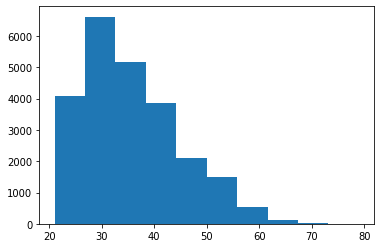

In [22]:
plt.hist(df['AGE'])

In [23]:
df['AGE'].describe()

count    23985.000000
mean        35.522243
std          9.254577
min         21.000000
25%         28.000000
50%         34.000000
75%         42.000000
max         79.000000
Name: AGE, dtype: float64

(array([1.0000e+00, 9.5500e+03, 1.0702e+04, 2.4140e+03, 8.4000e+02,
        2.9400e+02, 1.2000e+02, 5.3000e+01, 9.0000e+00, 2.0000e+00]),
 array([-157264. ,  -72573.3,   12117.4,   96808.1,  181498.8,  266189.5,
         350880.2,  435570.9,  520261.6,  604952.3,  689643. ]),
 <a list of 10 Patch objects>)

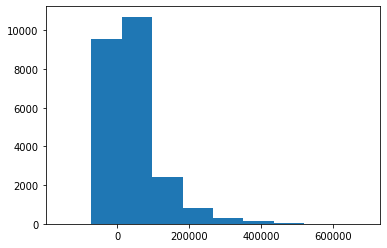

In [24]:
plt.hist(df['BILL_AMT3'] )

In [25]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,23985.0,11992.000000,6924.017439,0.0,5996.0,11992.0,17988.0,23984.0
Unnamed: 0.1,23985.0,11999.328622,6928.707171,0.0,5999.0,11999.0,18000.0,23998.0
LIMIT_BAL,23985.0,167636.009172,129608.115770,10000.0,50000.0,140000.0,240000.0,800000.0
SEX,23985.0,1.603586,0.489163,1.0,1.0,2.0,2.0,2.0
EDUCATION,23985.0,1.845945,0.746287,1.0,1.0,2.0,2.0,4.0
MARRIAGE,23985.0,1.556098,0.521821,1.0,1.0,2.0,2.0,3.0
AGE,23985.0,35.522243,9.254577,21.0,28.0,34.0,42.0,79.0
PAY_1,23985.0,-0.014843,1.121064,-2.0,-1.0,0.0,0.0,8.0
PAY_2,23985.0,-0.134626,1.193264,-2.0,-1.0,0.0,0.0,8.0
PAY_3,23985.0,-0.165520,1.193658,-2.0,-1.0,0.0,0.0,8.0


In [26]:
gender = df.groupby(['SEX', 'DEFAULT_PAY']).size().unstack(1)

In [27]:
gender

DEFAULT_PAY,0.0,1.0
SEX,,
1.0,7211,2297
2.0,11467,3010


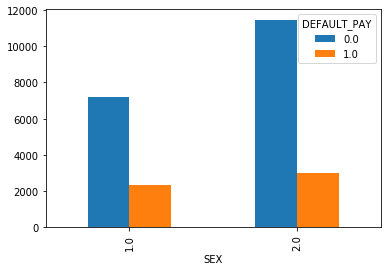

In [28]:
gender.plot(kind='bar')

In [29]:
gender['percent'] = (gender[1]/(gender[0] + gender[1])) 

In [30]:
gender

DEFAULT_PAY,0.0,1.0,percent
SEX,,,
1.0,7211,2297,0.241586
2.0,11467,3010,0.207916


In [31]:
gender.percent.mean()

0.2247510187557889

In [32]:
def corrl(Col1, Col2):
    res = df.groupby([Col1, Col2]).size().unstack()
    res['percent'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [33]:
corrl('EDUCATION', 'DEFAULT_PAY')

DEFAULT_PAY,0.0,1.0,percent
EDUCATION,,,
1.0,6820,1616,0.191560
2.0,8528,2655,0.237414
3.0,2979,1012,0.253571
4.0,351,24,0.064000


In [34]:
corrl('MARRIAGE', 'DEFAULT_PAY')

DEFAULT_PAY,0.0,1.0,percent
MARRIAGE,,,
1.0,8393,2559,0.233656
2.0,10052,2676,0.210245
3.0,233,72,0.236066


In [35]:
corrl('AGE', 'DEFAULT_PAY').sort_values('AGE')

DEFAULT_PAY,0.0,1.0,percent
AGE,,,
21.0,39.0,12.0,0.235294
22.0,325.0,142.0,0.304069
23.0,537.0,189.0,0.260331
24.0,657.0,232.0,0.260967
25.0,702.0,236.0,0.251599
26.0,797.0,208.0,0.206965
27.0,947.0,259.0,0.214760
28.0,910.0,229.0,0.201054
29.0,1023.0,255.0,0.199531


## 3. Feature Engineering

## 4. Feature Selection

In [36]:
df.head()

,Unnamed: 0,Unnamed: 0.1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_PAY,amount_owed6,amount_owed5,amount_owed4,amount_owed3,amount_owed2,late_pay
0,0.0,0.0,350000.0,1.0,1.0,2.0,37.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0
1,1.0,1.0,50000.0,2.0,2.0,1.0,37.0,2.0,2.0,2.0,0.0,0.0,0.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,0.0,580.0,600.0,600.0,600.0,0.0,12897.0,12668.0,12446.0,38222.0,38094.0,6.0
2,2.0,2.0,50000.0,2.0,1.0,2.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0,0.0,0.0,0.0,0.0,-22.0,-70.0,-6.0
3,3.0,3.0,20000.0,1.0,3.0,1.0,56.0,0.0,0.0,0.0,0.0,2.0,0.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,1216.0,1116.0,0.0,490.0,658.0,0.0,13196.0,13420.0,12668.0,11668.0,10668.0,2.0
4,4.0,4.0,110000.0,2.0,2.0,2.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,5400.0,4100.0,4100.0,4100.0,4200.0,0.0,101982.0,106457.0,104729.0,103064.0,101412.0,0.0


## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [37]:
X = df.drop('DEFAULT_PAY', axis = 1)
y= df['DEFAULT_PAY']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [41]:
y_pred =knn.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred)

0.9408037352009339

In [43]:
test_f1 = f1_score(y_test, y_pred)
test_f1

0.8610567514677103

## Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression


In [ ]:
logreg = LogisticRegression()

## Checking Min Max Scaler (KNN)
MinMax Scaler 

In [44]:
X = df.drop('DEFAULT_PAY', axis = 1)
y= df['DEFAULT_PAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [45]:
minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

In [46]:
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_train, y_train)
y_pred =knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9743204935801234

In [47]:
test_f1 = f1_score(y_test, y_pred)
test_f1

0.9409509202453987

## Optimal K values

In [48]:
k_scores = []

k_range = list(range(1, 12))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    test_f1 = f1_score(y_test, y_pred)
    
    k_scores.append(test_f1)
    print(k_scores)



[0.9262759924385633]
[0.9262759924385633, 0.9090909090909092]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504, 0.9409509202453987]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504, 0.9409509202453987, 0.9282634261074089]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504, 0.9409509202453987, 0.9282634261074089, 0.9408602150537635]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504, 0.9409509202453987, 0.9282634261074089, 0.9408602150537635, 0.9317738791423003]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504, 0.9409509202453987, 0.9282634261074089, 0.9408602150537635, 0.9317738791423003, 0.9416730621642364]
[0.9262759924385633, 0.9090909090909092, 0.9356680624286258, 0.925984251968504, 0.940950920245398

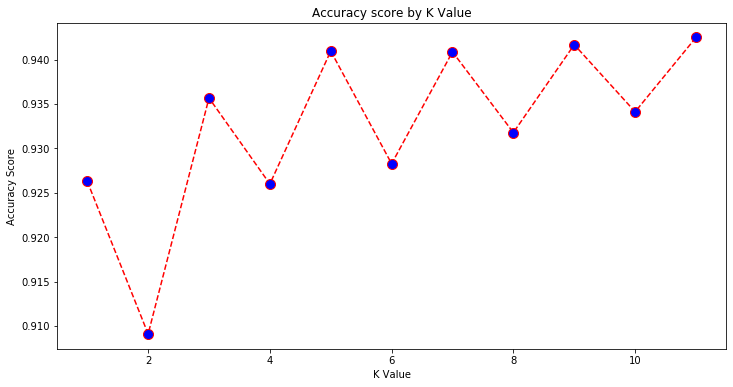

In [49]:
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()

In [54]:
#K OF 5 SEEMS TO BE THE BEST FOR ACCRACY SCORE

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)


## 6. Model Evaluation

## 7. Final Model